<h1>Simulation</h1>
<p>Hi Margaret what follows is a codebook that containes what I believe to be all the plots you requested.  There are sets of plots generated from 2 scenarios.  The first is when the continuous simulated is available at every location the categorical variable is recorded.  The second is when the continuous variable is scatted randomly throughout the spatial domain.  All plots have an annotation cell above them which describes the plot.  What immdiately follows is just my own rambles and </p>


<h3>Regularily Spaced Simulated Continuous Process</h3>
<p>This is the spatial domain where the categorical and continuous observations occur at the same location.  You had mentioned before the error rate for missclassifications.  I assumed 0 as I have never assumed missclassified spatial domains.  When mapping we often include an unknown category that is the garbage can for everything that cannot be positively id'ed then we assume no misclassifications for all other categories.  I mention this here mostly so I don't forget it and would like to ponder it more when the time presents.</p>

Text(0.5, 1.0, 'Spatial domain')

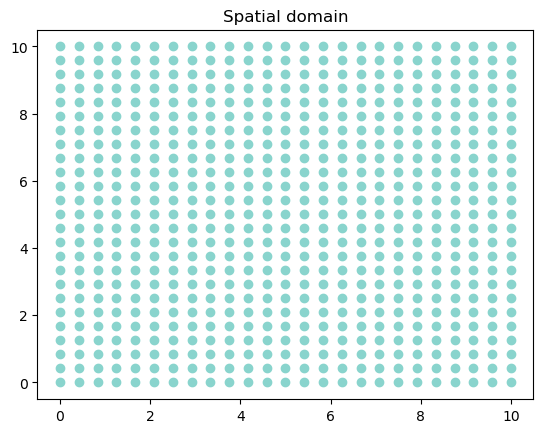

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
import seaborn as sns

#Define the spatial domain
n_points_X = 25
n_points_Y = 25

x = np.linspace(0, 10, n_points_X)
y = np.linspace(0, 10, n_points_Y)
X, Y = np.meshgrid(x, y)
locations = np.column_stack([X.ravel(), Y.ravel()])  #Shared locations
num_locations = len(locations)

plt.scatter(locations[:, 0], locations[:, 1], c="#89d4cd")
plt.title("Spatial domain")

<h2>Categorical Process</h2>
<p>What follow are 2 plots.  The raw Guassian process that is used to generate the categorical process and the classified categorical process which shows what each location is classified as.</p>

Text(0.5, 1.0, 'Categorical Process')

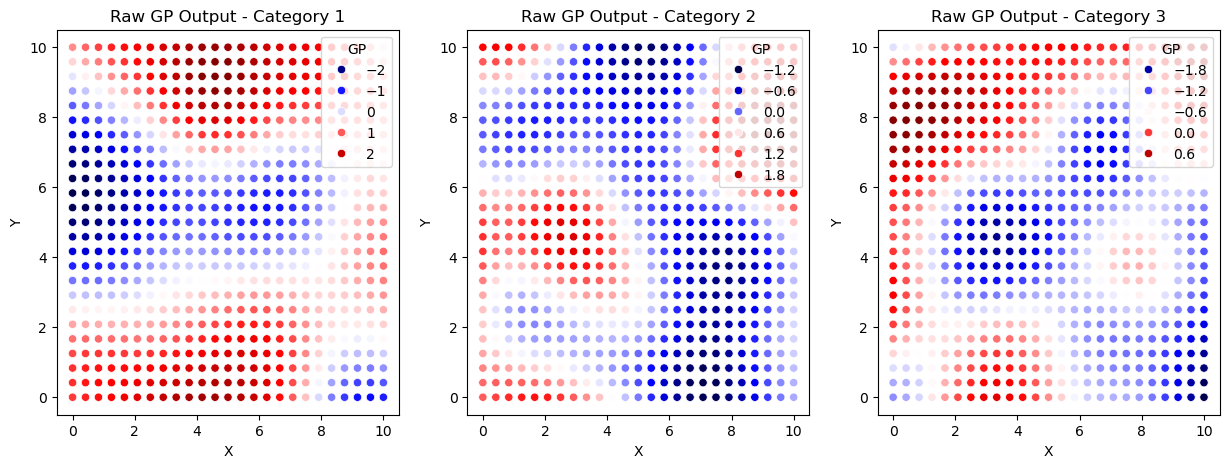

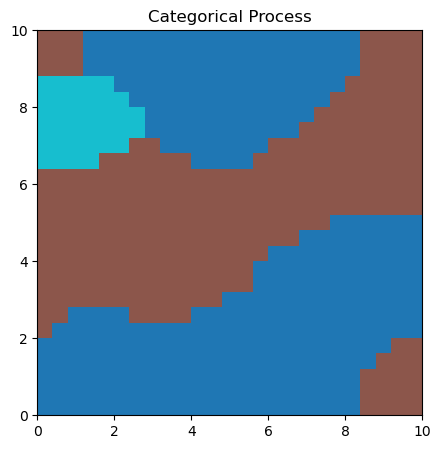

In [66]:
#Kernel function
def gaussian_kernel(locations, range=1.0, variance=1.0):
    distances = cdist(locations, locations, metric="euclidean")
    return variance * np.exp(-0.5 * (distances / range) ** 2)

#Parameters for kernels
k = 3  #Number of categories
range_cat = 2
variance_cat = 1


#Simulate the categorical process
cov_cat = gaussian_kernel(locations=locations, range=range_cat, variance=variance_cat)
gp_samples_cat = np.random.multivariate_normal(mean=np.zeros(num_locations), cov=cov_cat, size=k)
gp_stacked = np.stack(gp_samples_cat, axis=-1)
categories = np.argmax(gp_stacked, axis=-1).reshape(n_points_X, n_points_Y)  #2D array of categories
df = pd.DataFrame(zip(X.flatten(), Y.flatten(), gp_samples_cat.flatten()), columns=["X", "Y", "GP"])

df_list = []
for i in range(k):
    df_temp = pd.DataFrame({
        "X": X.flatten(),
        "Y": Y.flatten(),
        "GP": gp_samples_cat[i].flatten(),
        "Category": f"Category {i+1}"  #Label categories 1, 2, 3
    })
    df_list.append(df_temp)

df_all = pd.concat(df_list)

gp_stacked = np.stack(gp_samples_cat, axis=-1)
categories = np.argmax(gp_stacked, axis=-1).reshape(n_points_X, n_points_Y)  #2D categorical array

#Visualize the raw GP values for each category separately
fig, axes = plt.subplots(1, k, figsize=(15, 5))

for i, ax in enumerate(axes):
    df_cat = df_all[df_all["Category"] == f"Category {i+1}"]
    sns.scatterplot(data=df_cat, x="X", y="Y", hue="GP", ax=ax, palette="seismic", legend=True)
    ax.set_title(f"Raw GP Output - Category {i+1}")

#Visualize the categorical process
fig, ax_cat = plt.subplots(figsize=(5, 5))
ax_cat.imshow(categories, extent=(0, 10, 0, 10), origin='lower', cmap="tab10")
ax_cat.set_title("Categorical Process")

<h2>Discontinuity</h2>
<p>This cell begins to implement the blending affect over boundaries.  First I used a program to calculate the distance to the nearest boundary.  So below is a just a raster where each cell is classified by how far it is from the nearest boundary.</p>

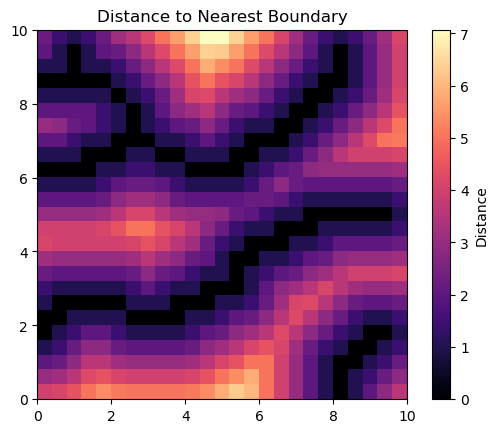

In [67]:
#Compute distance to boundaries
#Compute a boundary mask
boundary_mask = np.zeros_like(categories, dtype=bool)

for i in range(categories.shape[0] - 1):
    for j in range(categories.shape[1] - 1):
        if categories[i, j] != categories[i + 1, j] or categories[i, j] != categories[i, j + 1]:
            boundary_mask[i, j] = True

#Compute distances to the nearest boundary
distances_to_boundary = distance_transform_edt(~boundary_mask)

# Visualize distances to boundaries
plt.imshow(distances_to_boundary, extent=(0, 10, 0, 10), origin="lower", cmap="magma")
plt.title("Distance to Nearest Boundary")
plt.colorbar(label="Distance")
plt.show()


<h2>Continuous Process Simulation</h2>
<p>The continuous process is conditional on the categorical process.  Below category specific means can be specified, of note is that these will be benchmark parameters for a model that tries to predict this process.  This cell accepts a threshold distance at which the blending of values across the nearest boundary no longer occurs.  There is also a parameter \(\alpha\) that controls the sharpness of the blending process.  The blender works by weighting the mean and variances of the continuous process in each category where the weight \(w_{s_i} = e^{\alpha*d_{s_i}}\) where \(d_{s_i}\) is the distance to the nearest boundary for of each location.  This weight then interacts with the mean and variance of that parameterizes a normally distributed sample for that location.  I take it you'll be confused here.  So suffice it to say that this logic will need to need to be explained in greater detail, however, in the interest of getting you the plots it remains cursory for tonight.</p>

<p>The raster is hard to interpret.  There are also KDE plots showing how the distribution of after blending.  This example uses assumes constant variance in over the entire spatial domain but different means in category.  The means are [0, 50, 100] and represented by the dashed black lines.</p>

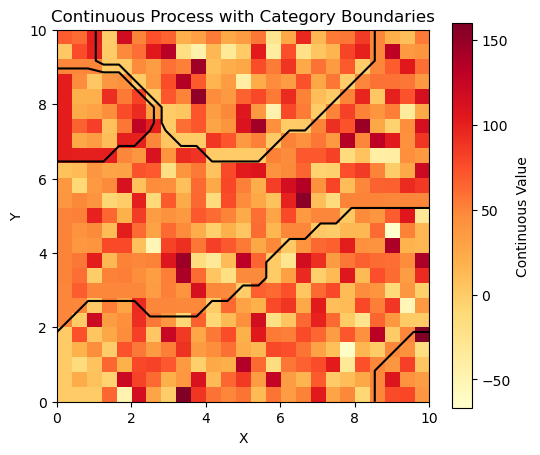

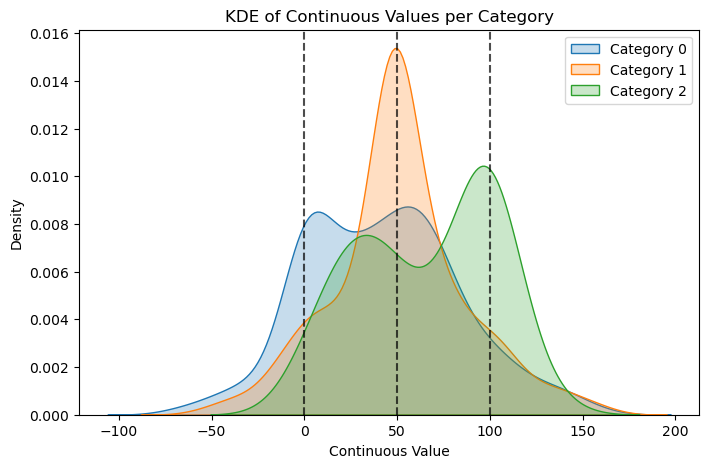

In [91]:
#Simulate the continuous process with blending
#Define category-specific parameters
mean_vector = [0, 50, 100]  #Means for each category
variance_vector = [1, 1, 1]  #Variances for each category
#define parameters for the continuous kernel function
range_cont = 2
variance_cont = 1

continuous_values = np.zeros(num_locations)

alpha = 3  #Controls blending sharpness
blending_threshold = 0.1  #Distance threshold for blending

#Simulate a spatially correlated field for each category
cov_cont = gaussian_kernel(locations, range=range_cont, variance=variance_cont)
spatial_fields = np.random.multivariate_normal(mean=np.zeros(num_locations), cov=cov_cont, size=k)

#get distances to nearest boundary
distances_to_boundary = distance_transform_edt(categories != np.roll(categories, shift=1, axis=0))
distances_to_boundary += distance_transform_edt(categories != np.roll(categories, shift=1, axis=1))

for i in range(num_locations):
    assigned_category = categories.ravel()[i]
    base_mean = mean_vector[assigned_category]
    base_variance = variance_vector[assigned_category]
    dist_to_boundary = distances_to_boundary.ravel()[i]

    if dist_to_boundary < blending_threshold:  # Blending region
        blended_mean = 0
        blended_variance = 0
        total_weight = 0
        
        for cat in range(k):  # Blend contributions from all categories
            weight = np.exp(-alpha * dist_to_boundary) + 1 # Stronger influence from assigned category
            blended_mean += weight * mean_vector[cat]
            blended_variance += weight * variance_vector[cat]
            total_weight += weight
        
        # Normalize blended mean and variance
        blended_mean /= total_weight
        blended_variance = sum(weight * (variance_vector[cat] + (mean_vector[cat] - blended_mean)**2) for cat in range(k)) / total_weight

        # Sample from the correctly parameterized normal distribution
        continuous_values[i] = np.random.normal(loc=blended_mean, scale=np.sqrt(blended_variance))
    
    else:  # Outside blending threshold: use spatially correlated field
        continuous_values[i] = spatial_fields[assigned_category, i] + base_mean

continuous_values_2D = continuous_values.reshape(n_points_X, n_points_Y)

#compute the boundaries
gradient_x, gradient_y = np.gradient(categories.astype(float))
boundaries = (np.abs(gradient_x) > 0) | (np.abs(gradient_y) > 0)  #Where category changes occur


#Visualize the continuous process as a raster
plt.figure(figsize=(6, 5))
plt.imshow(continuous_values_2D, extent=(0, 10, 0, 10), origin="lower", cmap="YlOrRd", interpolation="nearest")
plt.colorbar(label="Continuous Value")
plt.contour(categories, levels=[0.5, 1.5, 2.5], colors="black", linewidths=1.5, extent=(0, 10, 0, 10))
plt.title("Continuous Process with Category Boundaries")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#Check the blending logic
df_continuous = pd.DataFrame({
    "X": locations[:, 0],
    "Y": locations[:, 1],
    "Category": categories.ravel(),
    "Continuous Value": continuous_values
})

# Set up the plot
plt.figure(figsize=(8, 5))

for cat in range(k):
    subset = df_continuous[df_continuous["Category"] == cat]
    sns.kdeplot(subset["Continuous Value"], label=f"Category {cat}", fill=True)

    # Overlay vertical lines for expected means
    plt.axvline(mean_vector[cat], linestyle="dashed", color="black", alpha=0.7)

# Labels and legend
plt.xlabel("Continuous Value")
plt.ylabel("Density")
plt.title("KDE of Continuous Values per Category")
plt.legend()
plt.show()

<h2>More realistic</h2>
<p>I think I have provided all the plots and 2 additional plots that you requested from Tuesday.  The following is simply a spatial process simulator that does not require that categorical and continuous processes are at the same locations.  Of interest to the scope of the problem, determining what likelihood function to use to make infernece on this process, I do not believe that this is revelant right now.  Thanks.</p>

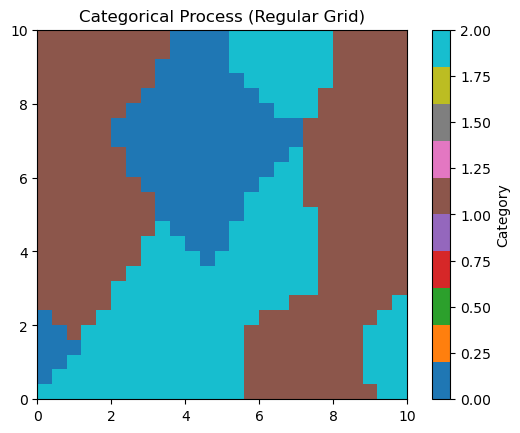

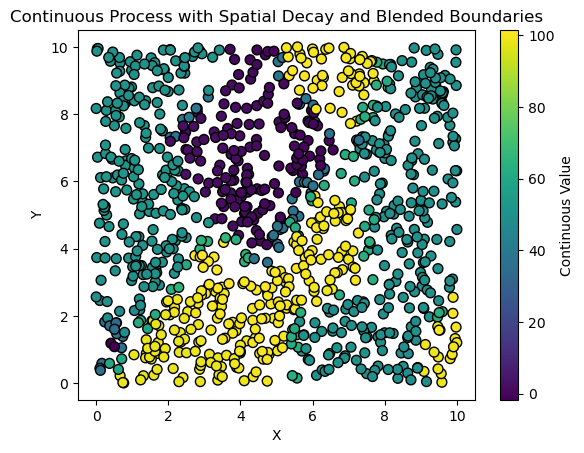

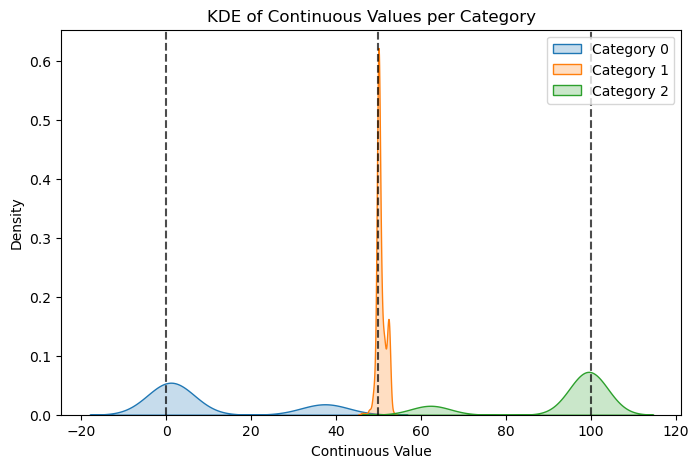

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt

#Define the spatial domain for the categorical process
n_points_X = 25
n_points_Y = 25
x = np.linspace(0, 10, n_points_X)
y = np.linspace(0, 10, n_points_Y)
X, Y = np.meshgrid(x, y)
locations_cat = np.column_stack([X.ravel(), Y.ravel()])  #Grid locations

#Generate random points for the continuous process
num_random_points = 1000
random_x = np.random.uniform(0, 10, num_random_points)
random_y = np.random.uniform(0, 10, num_random_points)
locations_cont = np.column_stack([random_x, random_y])  #Scattered points

#Kernel function
def gaussian_kernel(locations, range=1.0, variance=1.0):
    distances = cdist(locations, locations, metric="euclidean")
    return variance * np.exp(-0.5 * (distances / range) ** 2)

#Step 1: Simulate the categorical process
k = 3  # Number of categories
range_cat = 2
variance_cat = 2
cov_cat = gaussian_kernel(locations=locations_cat, range=range_cat, variance=variance_cat)
gp_samples_cat = np.random.multivariate_normal(mean=np.zeros(len(locations_cat)), cov=cov_cat, size=k)
gp_stacked = np.stack(gp_samples_cat, axis=-1)
categories = np.argmax(gp_stacked, axis=-1).reshape(n_points_X, n_points_Y)  # 2D grid of categories

#Visualize the categorical process
plt.imshow(categories, extent=(0, 10, 0, 10), origin="lower", cmap="tab10")
plt.title("Categorical Process (Regular Grid)")
plt.colorbar(label="Category")
plt.show()

#Step 2: Compute distance to category boundaries (grid-based)
boundary_mask = np.zeros_like(categories, dtype=bool)
for i in range(categories.shape[0] - 1):
    for j in range(categories.shape[1] - 1):
        if categories[i, j] != categories[i + 1, j] or categories[i, j] != categories[i, j + 1]:
            boundary_mask[i, j] = True
distances_to_boundary = distance_transform_edt(~boundary_mask).ravel()

#Assign categories to scattered points (nearest neighbor on the grid)
dist_to_grid = cdist(locations_cont, locations_cat)
closest_grid_indices = np.argmin(dist_to_grid, axis=1)
assigned_categories = categories.ravel()[closest_grid_indices]

#Step 3: Simulate a spatially correlated field for the continuous process
range_cont = 2
variance_cont = 1
cov_cont = gaussian_kernel(locations_cont, range=range_cont, variance=variance_cont)
spatial_field = np.random.multivariate_normal(mean=np.zeros(num_random_points), cov=cov_cont)

#Define category-specific parameters
mean_vector = [0, 50, 100]  #Means for each category
variance_vector = [1, 1, 1]  #Variances for each category

#Simulate the continuous process at scattered points
continuous_values = np.zeros(num_random_points)
alpha = 1.0  # Controls blending sharpness
blending_threshold = 0.1  # Distance threshold for blending

for i in range(num_random_points):
    assigned_category = assigned_categories[i]  # Get category for current point
    base_mean = mean_vector[assigned_category]
    base_variance = variance_vector[assigned_category]
    
    # Get distance to nearest boundary for current point
    dist_to_boundary = distances_to_boundary[closest_grid_indices[i]]

    if dist_to_boundary < blending_threshold:  # In blending region
        # Initialize blending parameters
        blended_mean = 0
        blended_variance = 0
        total_weight = 0
        
        # Get weights for each category based on distance
        for cat in range(k):
            weight = np.exp(-alpha * dist_to_boundary)
            if cat == assigned_category:
                weight *= 2  # Double weight for assigned category
            
            blended_mean += weight * mean_vector[cat]
            blended_variance += weight * variance_vector[cat]
            total_weight += weight
        
        # Normalize blended parameters
        blended_mean /= total_weight
        blended_variance /= total_weight
        
        # Sample from blended distribution
        continuous_values[i] = np.random.normal(
            loc=blended_mean + spatial_field[i], 
            scale=np.sqrt(blended_variance)
        )
    else:  # Away from boundaries
        continuous_values[i] = spatial_field[i] + base_mean
    

#Step 4: Visualize the continuous process (scattered points)
plt.scatter(random_x, random_y, c=continuous_values, cmap="viridis", s=50, edgecolor="k")
plt.title("Continuous Process with Spatial Decay and Blended Boundaries")
plt.colorbar(label="Continuous Value")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


#Check the blending logic
df_continuous = pd.DataFrame({
"X": random_x,
"Y": random_y,
"Category": assigned_categories,
"Continuous Value": continuous_values
})

# Set up the plot
plt.figure(figsize=(8, 5))

for cat in range(k):
    subset = df_continuous[df_continuous["Category"] == cat]
    sns.kdeplot(subset["Continuous Value"], label=f"Category {cat}", fill=True)

    # Overlay vertical lines for expected means
    plt.axvline(mean_vector[cat], linestyle="dashed", color="black", alpha=0.7)

# Labels and legend
plt.xlabel("Continuous Value")
plt.ylabel("Density")
plt.title("KDE of Continuous Values per Category")
plt.legend()
plt.show()

<h2>Project</h2>
<p>This simulation is created to study the applicability of spatial process convolutions for resource modelling.  Often resource estimation is broken into several stages.  A geological model is first created that attempts to define lithological structures and units in the spatial domain.  The model is refined at the domaining stage to smaller domains that are believed to control mineralization and often assumptions about variance are introduced at this stage.  Estimations are then conducted in the domains by applying Kriging functions.  The end product is a block model of the estimated grades where block dimensions are determined by a minimal mining width.  Generally these blocks are 5x5' for an underground, high grade mineralization style and model extents are the stope extents. A stope is a mine engineering tool that involves shooting out material between two levels.  These levels are usually 50' to 200' vertically separated depending on ground conditions and no more than 20x15' in the x and y.</p>

<p>This simulation is part of a wider exploration of how to integrate different stages of the resource estimation process.  Fundementally, the geological model can be represented as a categorical process and the numeric model is a continuous process.  The numeric process is conditioned on the categorical process which is geologically supported as we know that mineralization is highly dependent on geological units.  In a sense, could a numeric estimation be distilled to simply mapping a region and then selecting knot locations for the continuous process?</p>